# 0.0 IMPORTS

In [1]:
import inflection
import math
import datetime

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython.display import Image

## 0.2 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# merge (Unindo os arquivos a partir do store, coluna comun aos dois arquivoc, a fim de montar um tabelão com os dados de venda e as características da loja. LEmbre-se da união de tabelas no SQL)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 DESCRIÇÃO DOS DADOS (Passo 1)

In [5]:
# Cópia do DF - neste caso o meigraom fez pois não precisar rodar o código completo se der algum erro, apenas a seção
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Renomeando as colunas com a função lambda

snakecase = lambda x: inflection.underscore(x)
# map vai mapear a função snakecase em todas as palavras da lista cols_old
cols_new = list ( map( snakecase, cols_old ) )

# rename 
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of Rows: {}'.format (df1.shape[0]))
print('Number of Columns: {}'.format (df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
# alterando o tipo da coluna data de object para date
df1['date'] = pd.to_datetime( df1 ['date'] )

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
# somando as linhas vazias

df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance: distancia até um competidor          
# max_value 20000 if math.isna(df1['competition_distance']) else df1 ['competition_distance'] - raciocínio
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

# competition_open_since_month: data da última competição. Para os NA's copiar data da última venda
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year   
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )
                       
# promo2_since_week: data da continuidade da última promoção
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

# promo2_since_year     
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# promo_interval: intervalo de meses em que apromoção 2 foi ativa. A ideia é criar uma coluna auxiliar dizendo sim ou não.
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna( 0 , inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] ==0 else 1 if x['month_map'] in x['promo_interval'].split ( ',' ) else 0, axis=1 )

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [12]:
df1.sample(10).T

,882524,682242,896335,242471,537138,858464,254745,66715,765077,520785
store,230,648,661,576,494,700,725,931,973,866
day_of_week,3,1,5,4,5,4,5,2,4,6
date,2013-05-01 00:00:00,2013-10-28 00:00:00,2013-04-19 00:00:00,2014-12-25 00:00:00,2014-03-07 00:00:00,2013-05-23 00:00:00,2014-12-12 00:00:00,2015-06-02 00:00:00,2013-08-15 00:00:00,2014-03-22 00:00:00
sales,0,4677,6449,0,8407,0,5841,4210,5583,7097
customers,0,515,566,0,1198,0,590,497,709,501
open,0,1,1,0,1,0,1,1,1,1
promo,1,0,0,0,1,0,0,1,1,0
state_holiday,a,0,0,c,0,0,0,0,0,0
school_holiday,0,0,0,1,0,0,0,0,1,0
store_type,d,d,d,c,b,a,d,a,d,d


## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [14]:
# Separando as colunas númericas
num_attributes = df1.select_dtypes( include=[ 'int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [15]:
# Central Tendence
ct1 = pd.DataFrame( num_attributes.apply ( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median) ).T

# Dispercion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply ( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply (min) ).T
d3 = pd.DataFrame( num_attributes.apply (max) ).T
d4 = pd.DataFrame( num_attributes.apply (lambda x: (x.max() - x.min()) ) ).T
d5 = pd.DataFrame( num_attributes.apply (lambda x: x.skew () ) ).T
d6 = pd.DataFrame( num_attributes.apply (lambda x: x.kurtosis () ) ).T


#Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = [ 'atributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


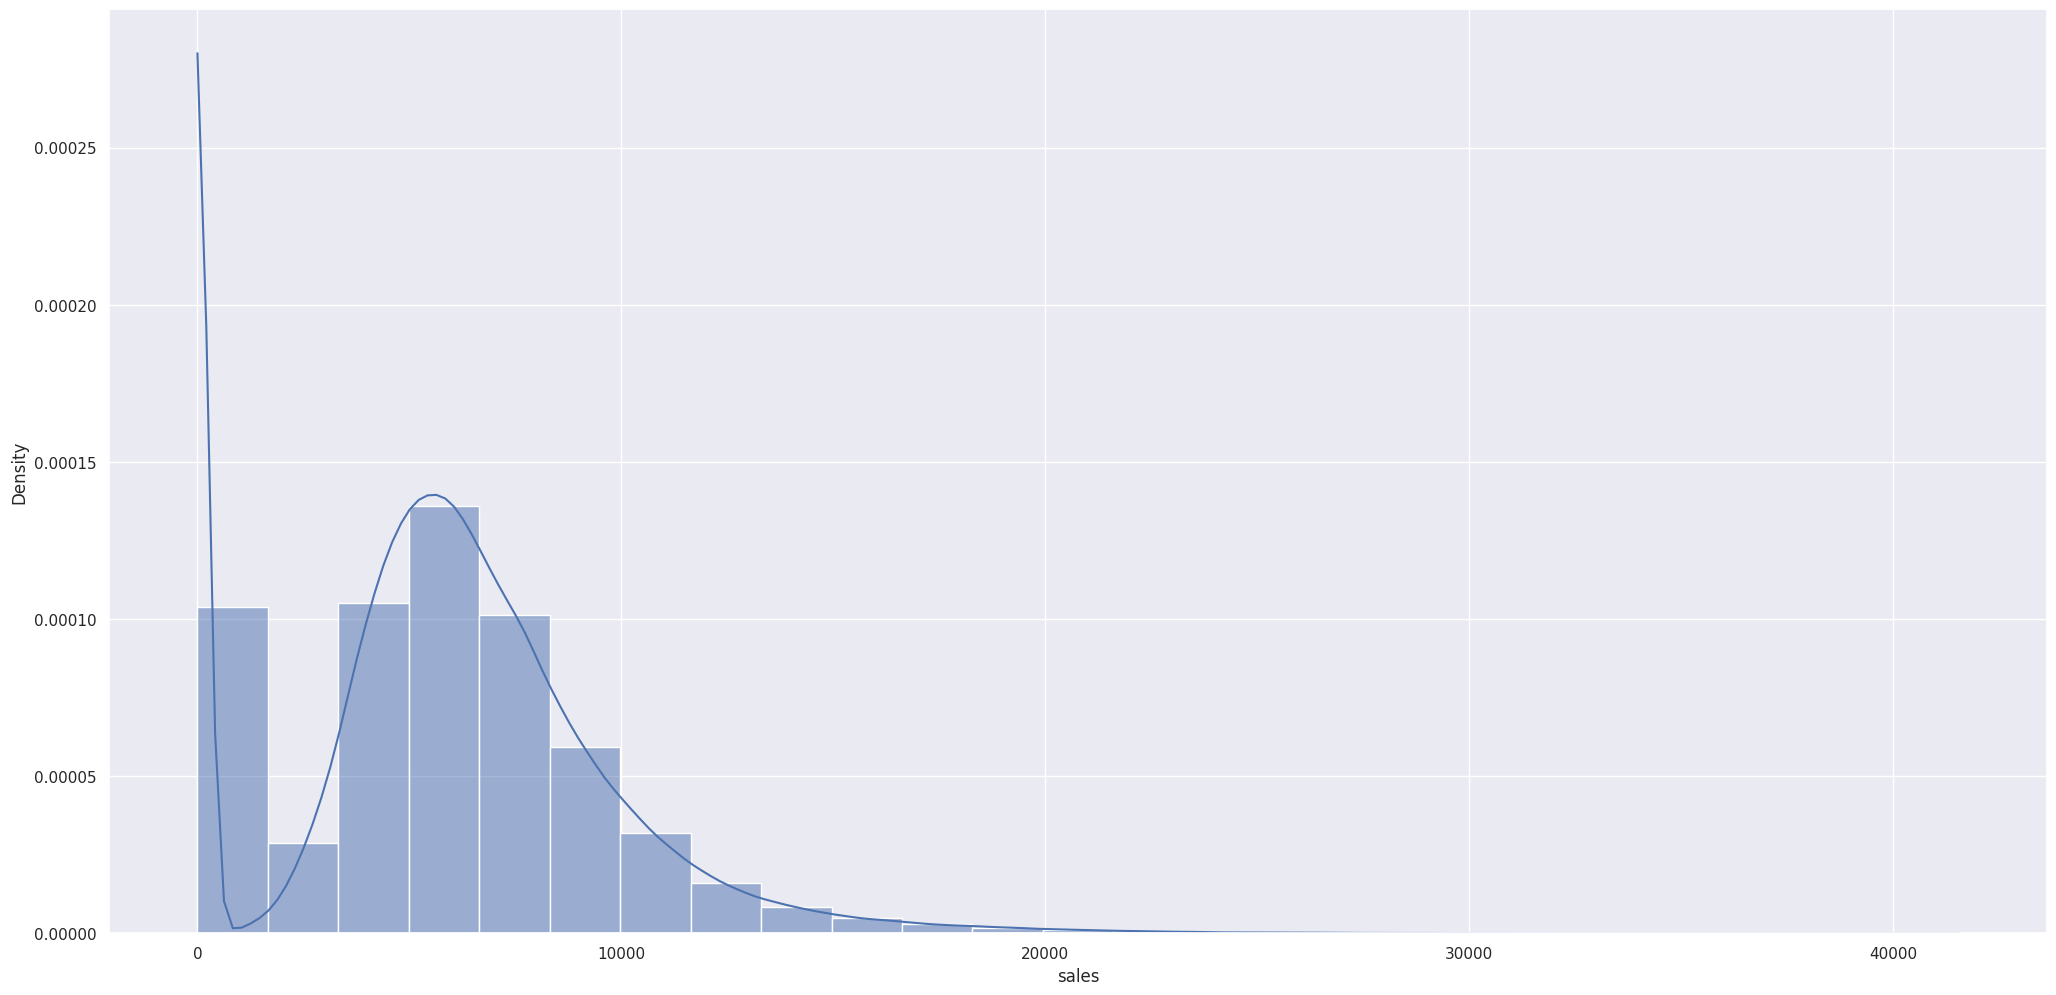

In [16]:
sns.histplot( df1['sales'], kde=True, stat="density" , bins=25 );

## 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

/tmp/ipykernel_2904/3544381987.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação
/tmp/ipykernel_2904/3544381987.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação
/tmp/ipykernel_2904/3544381987.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação
/tmp/ipykernel_2904/3544381987.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(axes[3].get_xt

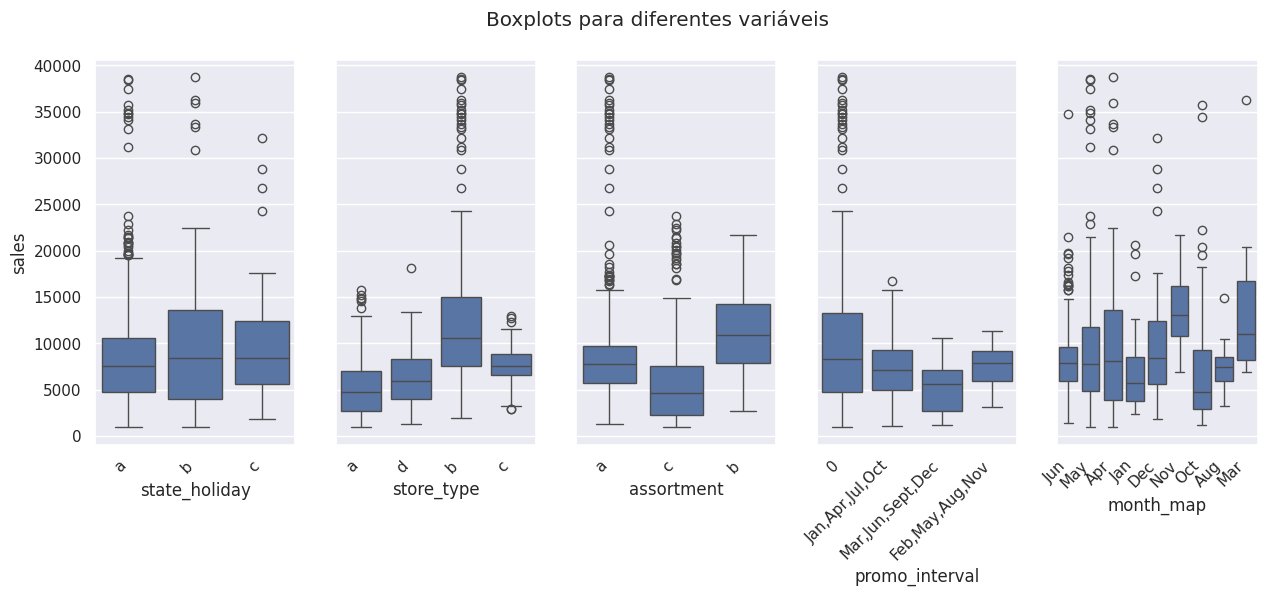

In [18]:
# Filtrando o dataset
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

# Configuração do subplot
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Boxplots
sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='promo_interval', y='sales', data=aux1, ax=axes[3])
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

sns.boxplot(x='month_map', y='sales', data=aux1, ax=axes[4])
axes[4].set_xticklabels(axes[4].get_xticklabels(), rotation=45, ha='right')  # Ajuste de rotação

# Ajusta o título do subplot
plt.suptitle('Boxplots para diferentes variáveis')

# Exibe o gráfico
plt.show()


# 2.0 FEATURE ENGINEERING (Passo 2)

In [19]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

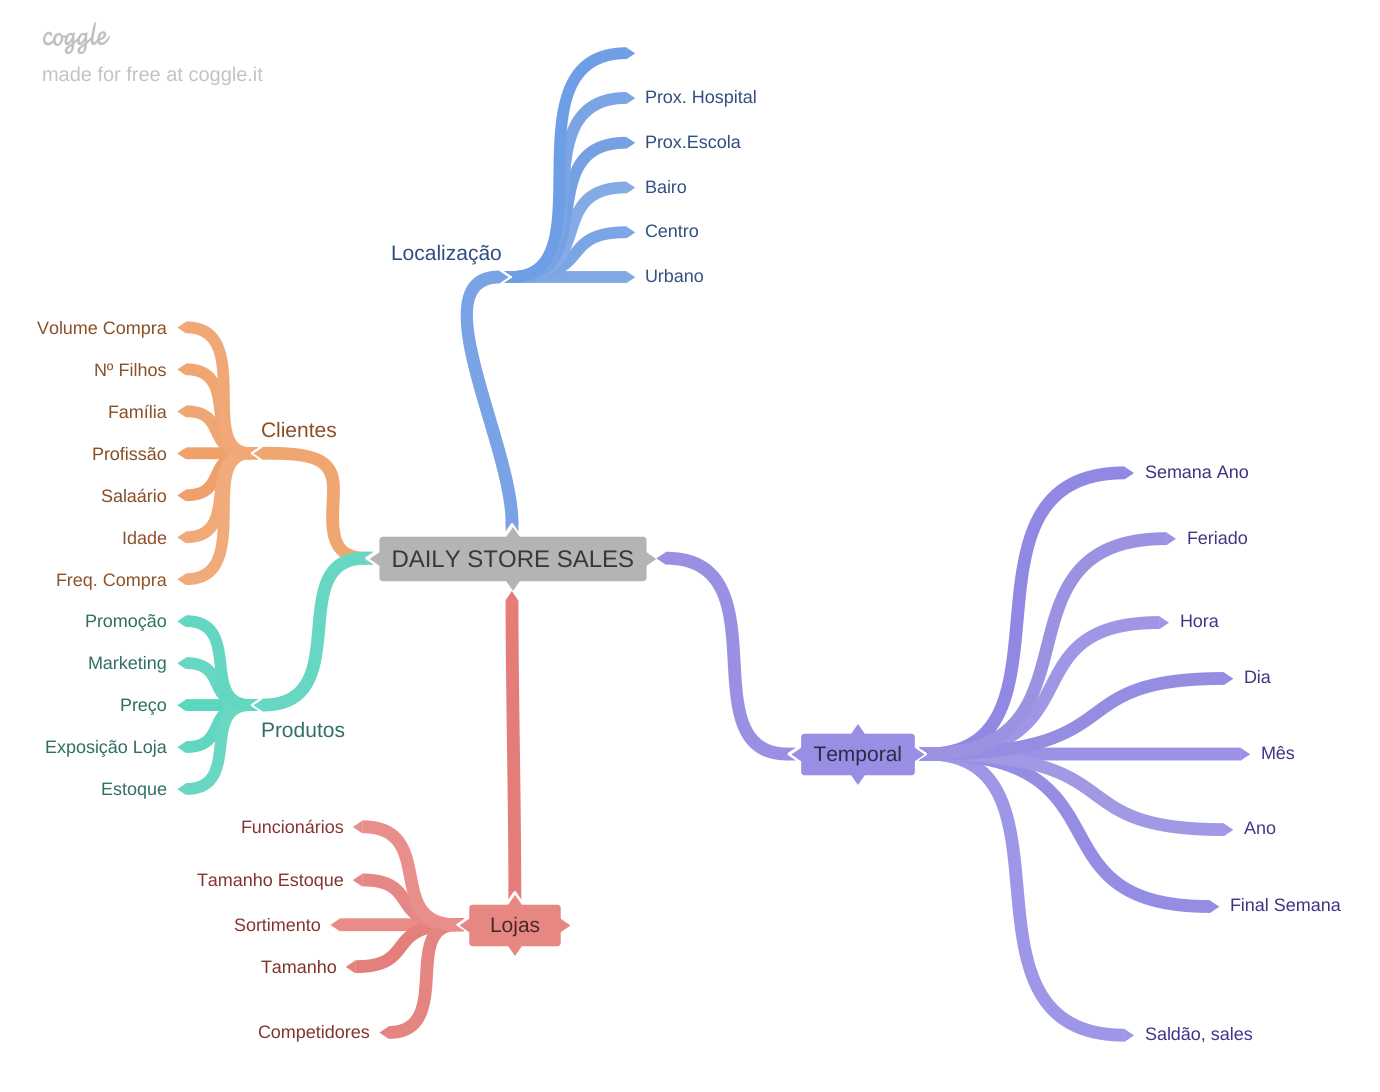

In [20]:
Image( 'img/MindMapHypothesis.png' )

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses da Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com estoque maior deveriam vender mais.

**3.** Lojas com maior sortimento deveriam vender mais.

**4.** Lojas maiores deveriam vender mais.

**5.** Lojas com menos competidores devereiam vender menos.

### 2.2.2 Hipóteses do Produto

**1.** Lojas com promoções deveriam vender mais.

**2.** Lojas que investem em marketing deveriam vender mais.

**3.** Lojas com produtos mais caros deveriam vender menos.

**4.** Lojas com produtos mais expostos vendem mais.

**5.** Lojas com poucos produtos em estoque deveriam vender menos.

**6.** Lojas com produtos mais baratos por mais tempos deveriam vender mais.

### 2.2.3 Hipóteses Temporal

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primieros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas com funcionamento superior a 10 horas diarias deveriam vender mais.

**5.** Lojas com menos saldão deveriam vender menos.

**6.** Lojas que abrem nas últimas 4 semanas do ano deveriam vender mais.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos devereiam vender menos.

**3.** Lojas com competidores a mais tempo devereiam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções censecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [21]:
# Derivando variáveis

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.strftime( '%V' )

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime ( year=x['competition_open_since_year'], month=x['competition_open_since_month'] , day=1 ), axis=1 )
df2['competition_time_month']= ( ( df2['date'] - df2['competition_since'])/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply ( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extendend' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day' )



In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DAS VARIÁVEIS (Passo 3)

In [23]:
df3 = df2.copy()

In [24]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Filtragem das linhas

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extendend,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas 

In [27]:
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 ANÁLISE EXPLORATORIA DOS DADOS (Passo 4)

In [28]:
df4 = df3.copy()

   ## 4.1 Análise Univariada

### 4.1.1 Response Variable

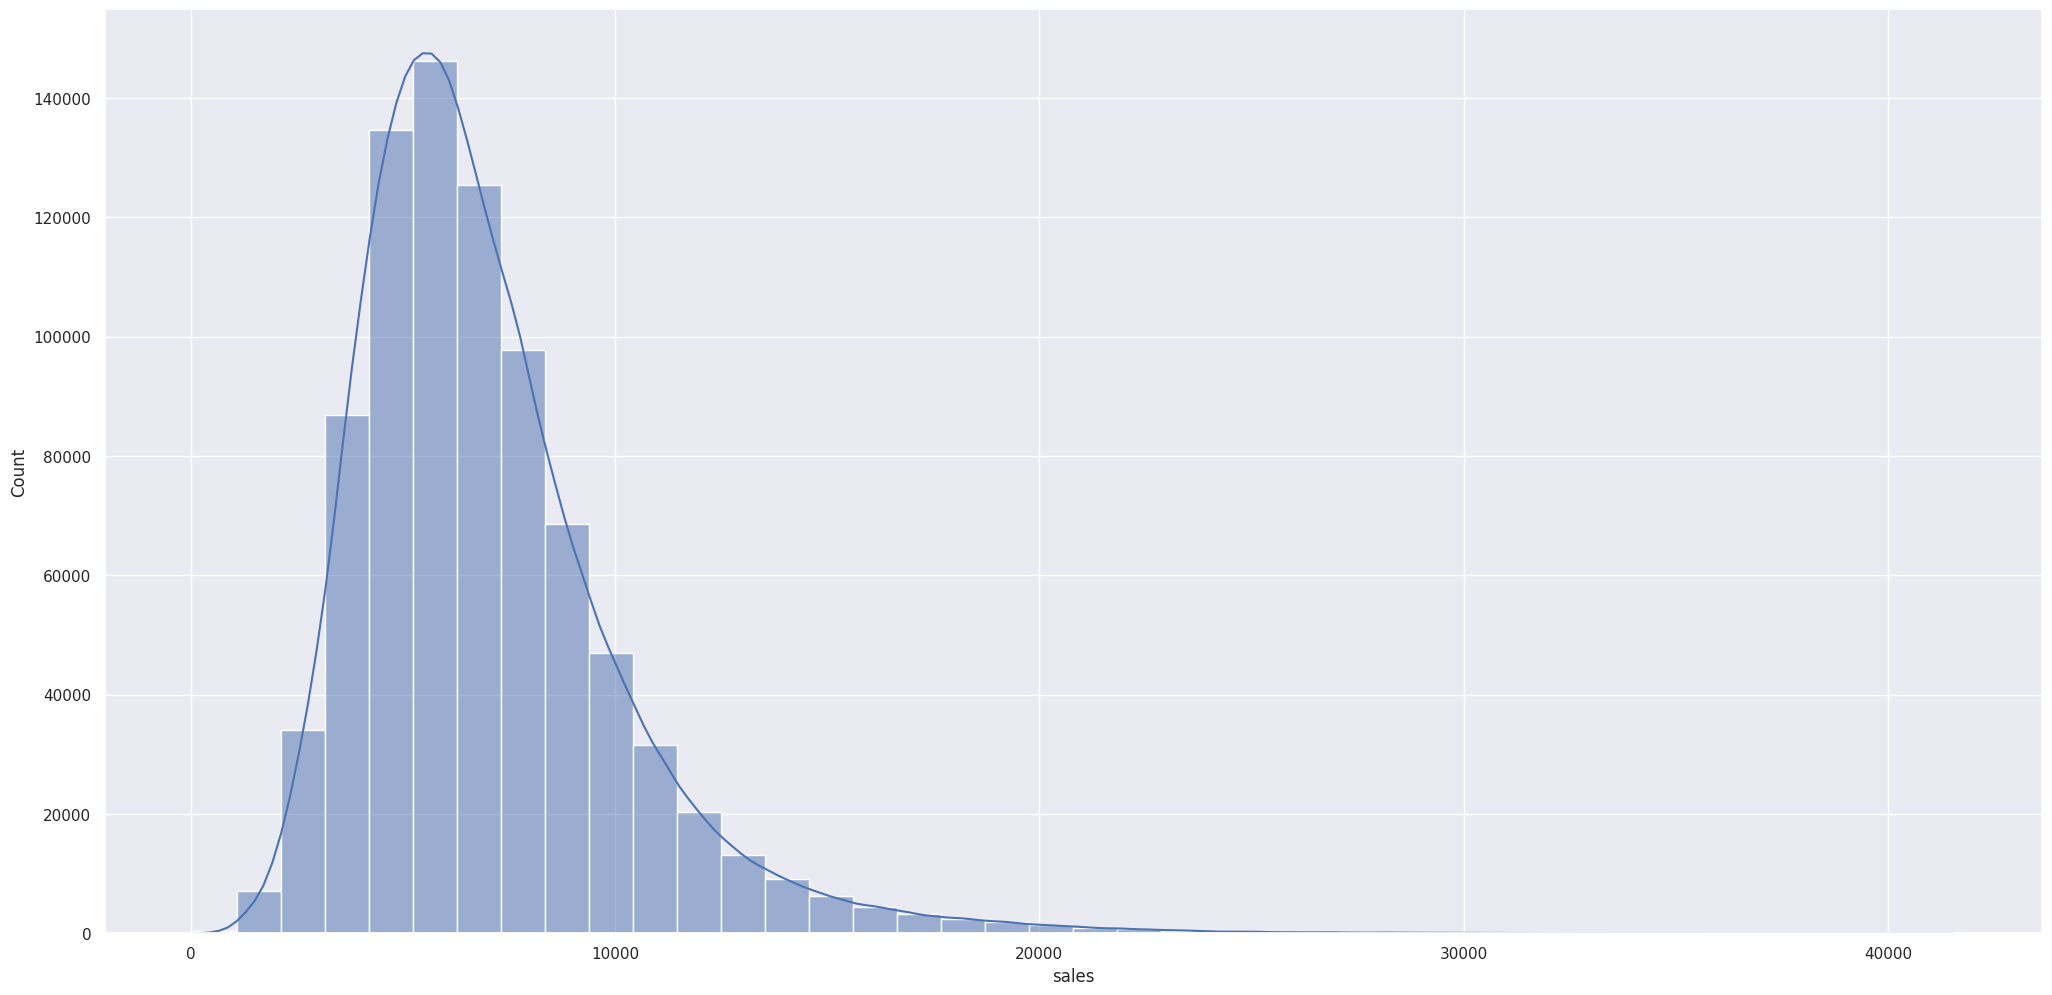

In [29]:
sns.histplot(df4['sales'], kde=True, bins=40 );

### 4.1.2 Numerical Variable

<Axes: xlabel='year_week'>

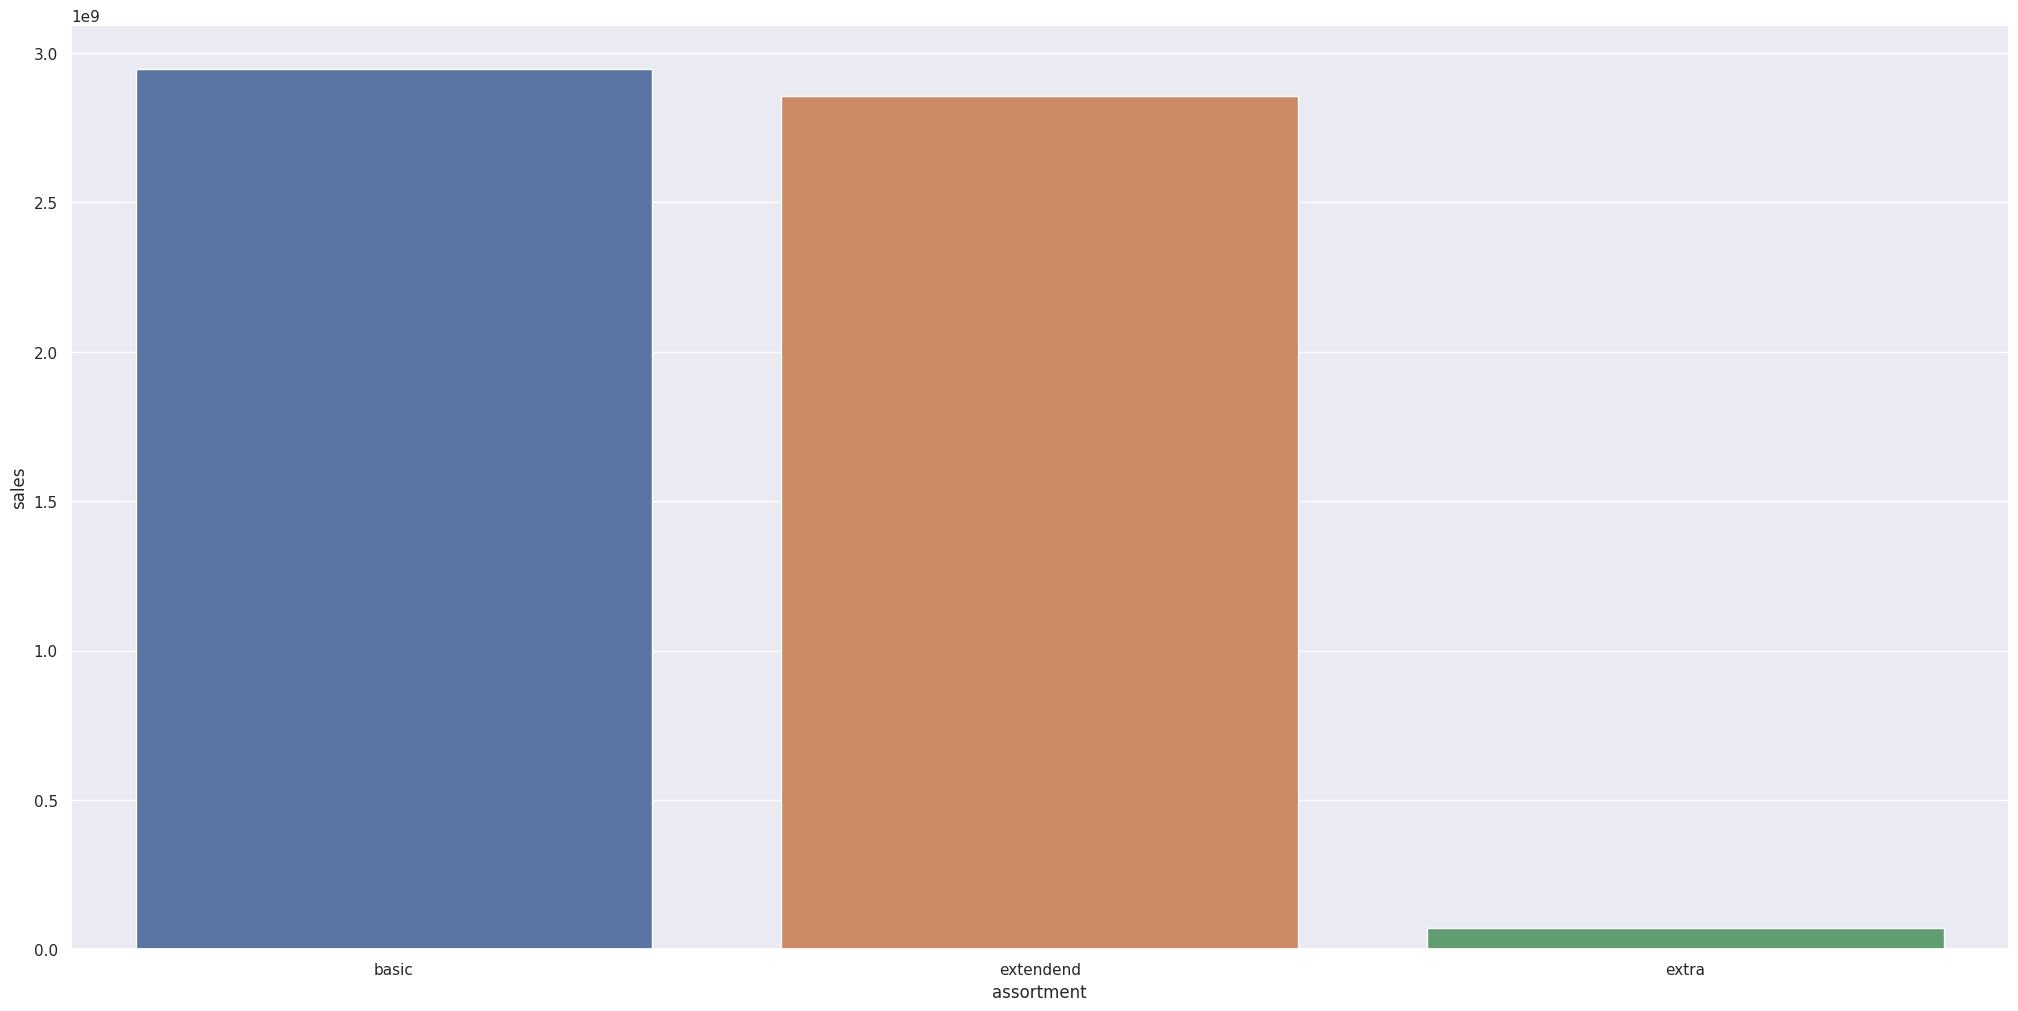

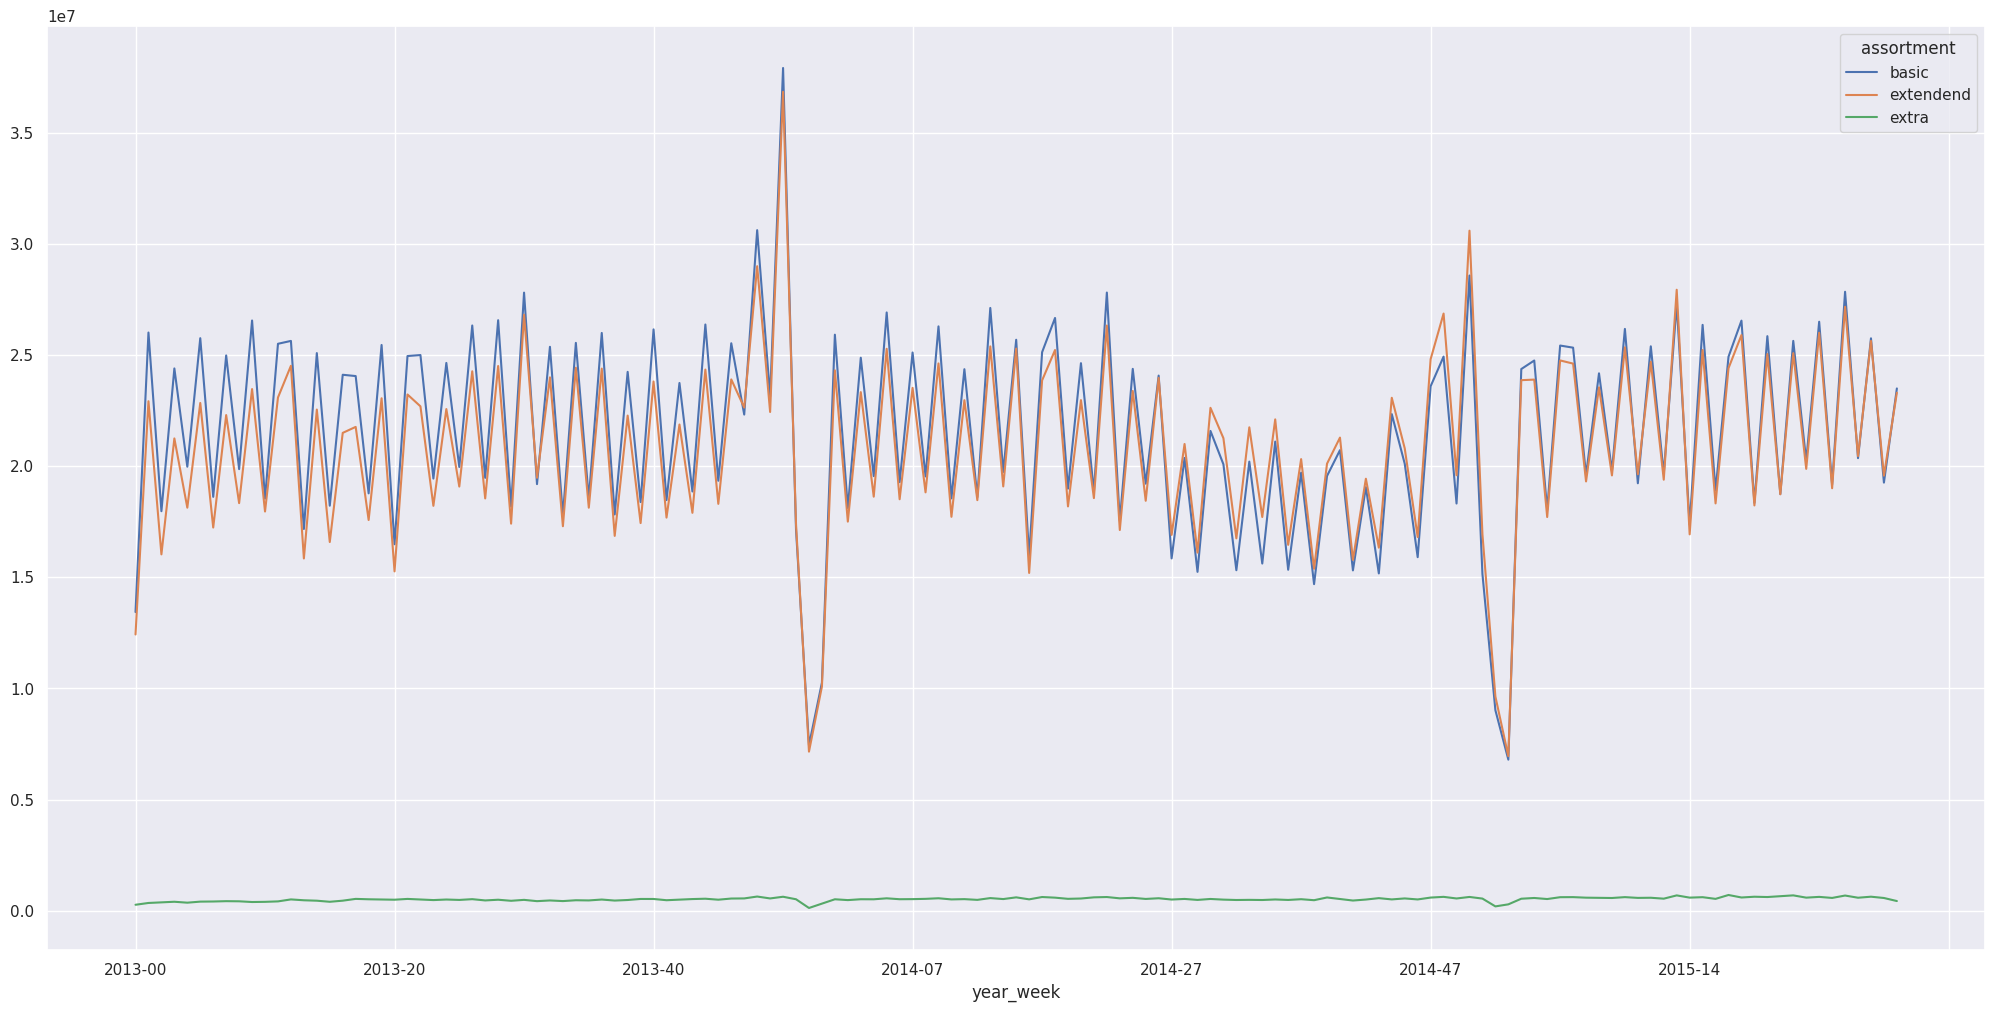

In [30]:
aux1 = df4[['assortment', 'sales']].groupby(['assortment']).sum().reset_index()
sns.barplot ( x='assortment', y='sales', data=aux1, hue='assortment', legend=False );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales'  ).plot();

### 4.1.3 Categorical Variable

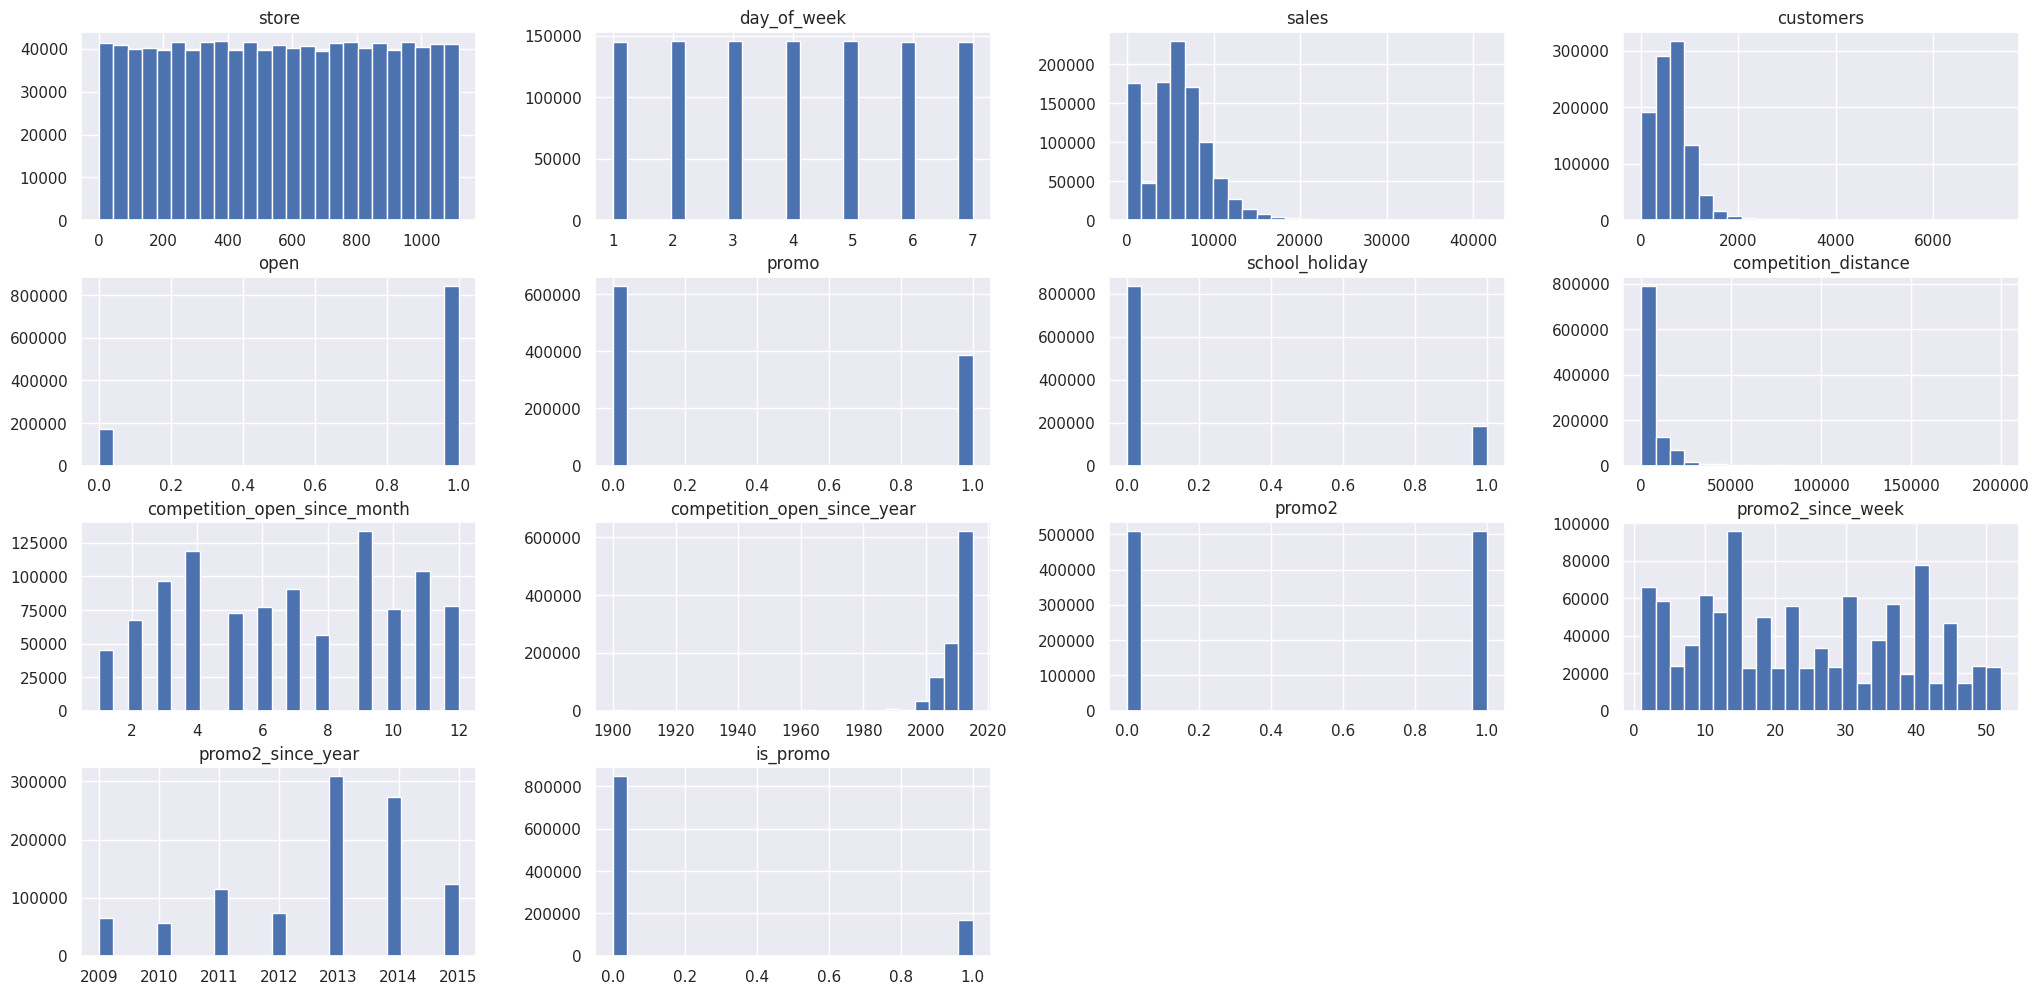

In [31]:
num_attributes.hist( bins=25 );

<Axes: xlabel='sales', ylabel='Density'>

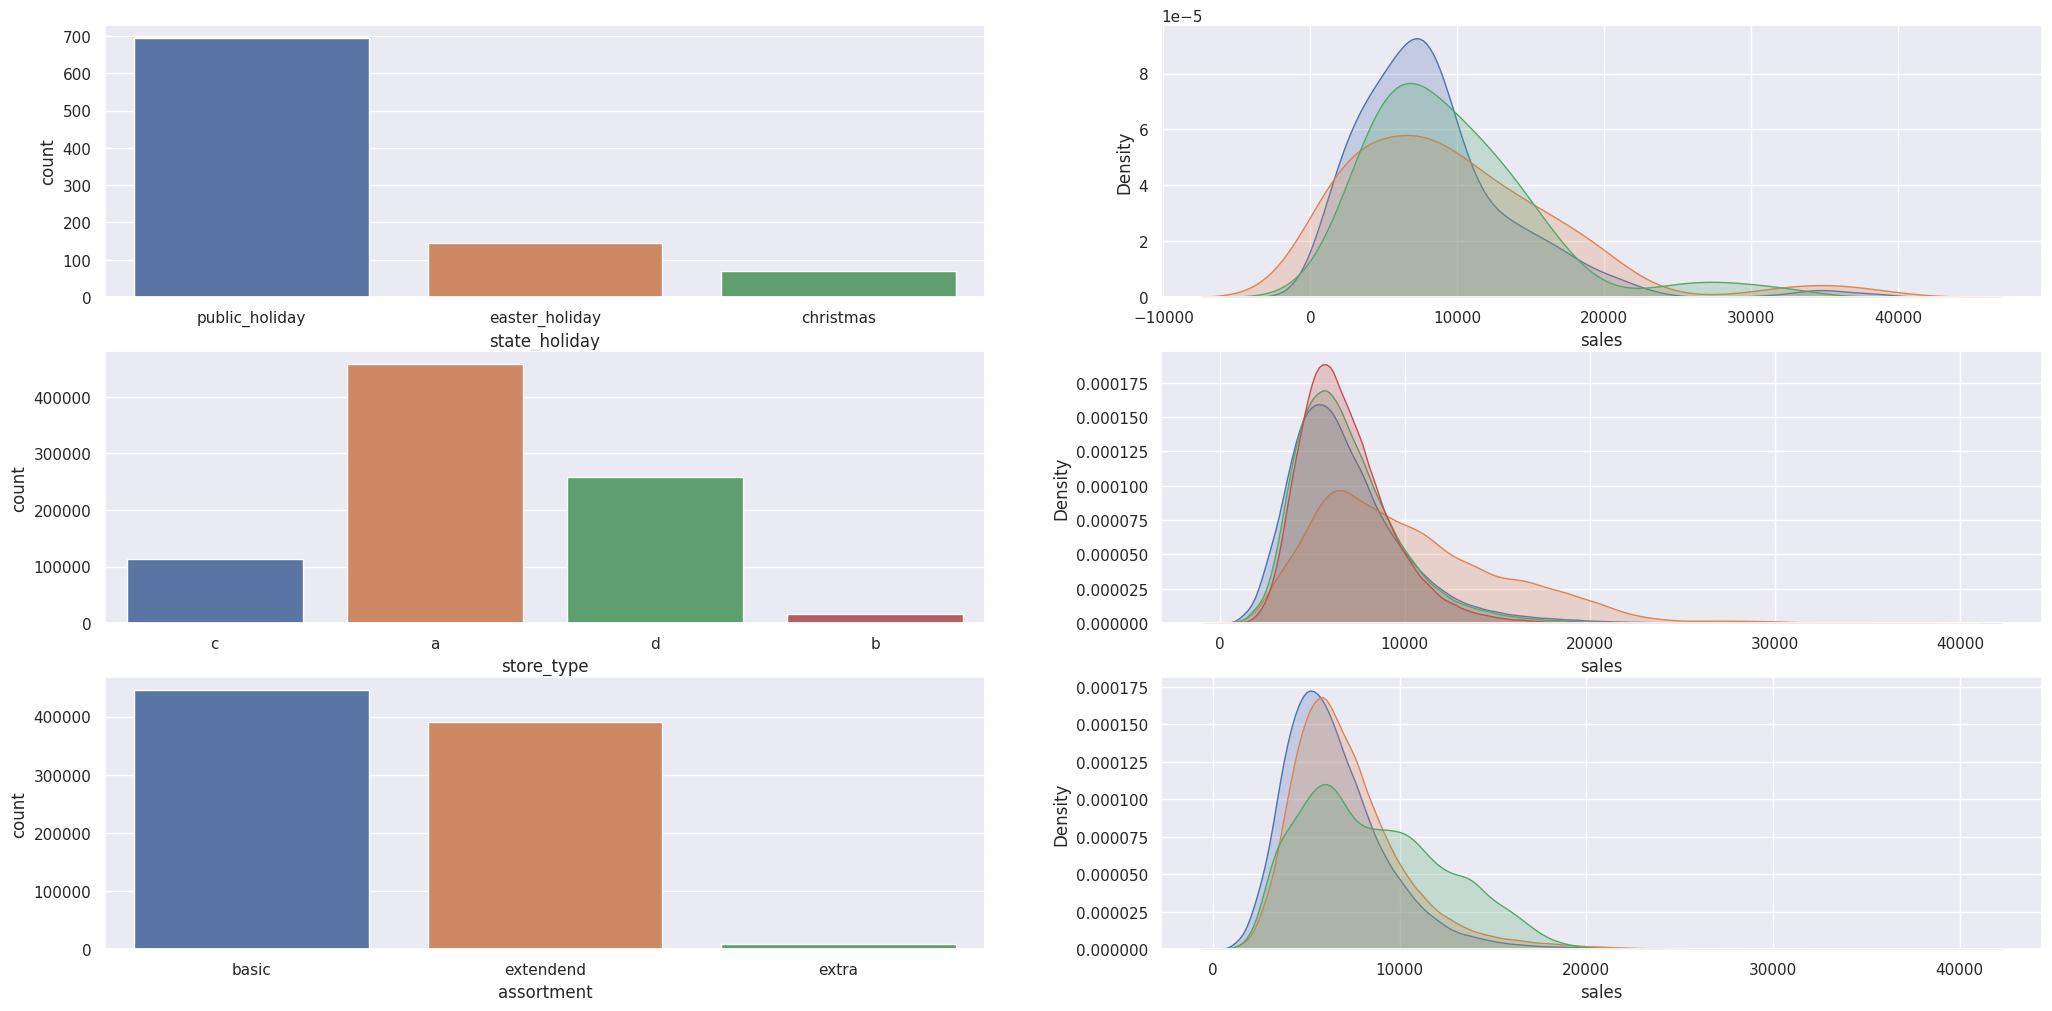

In [32]:
# state_holiday
plt.subplot ( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x='state_holiday', data=a, hue='state_holiday', legend=False );

plt.subplot ( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True );
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True );
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True );

# store_type
plt.subplot ( 3, 2, 3)
sns.countplot( x='store_type', data=df4, hue='store_type', legend=False );

plt.subplot ( 3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True );
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True );

#assortment
plt.subplot ( 3, 2, 5)
sns.countplot( x='assortment', data=df4, hue='assortment', legend=False );

plt.subplot ( 3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True );
sns.kdeplot(df4[df4['assortment'] == 'extendend']['sales'], label='extendend', fill=True );
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True );



   ## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

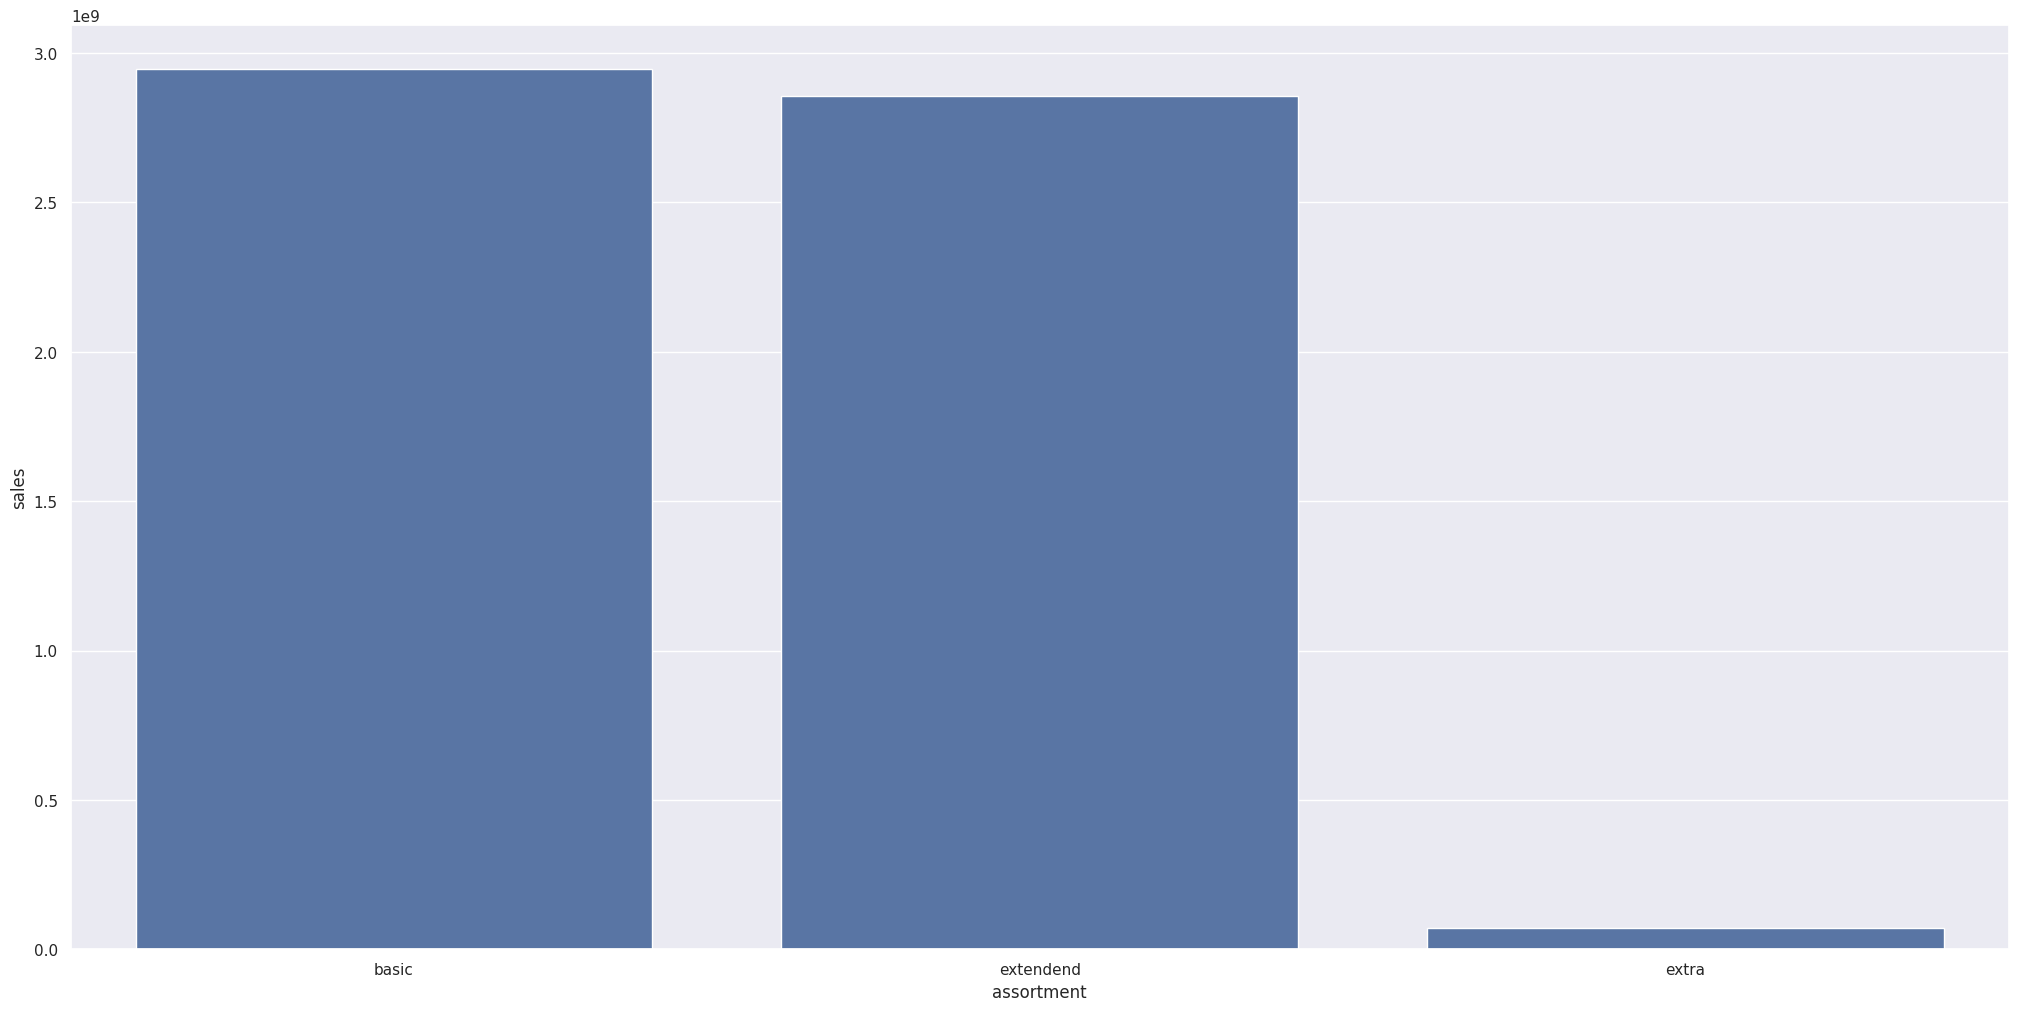

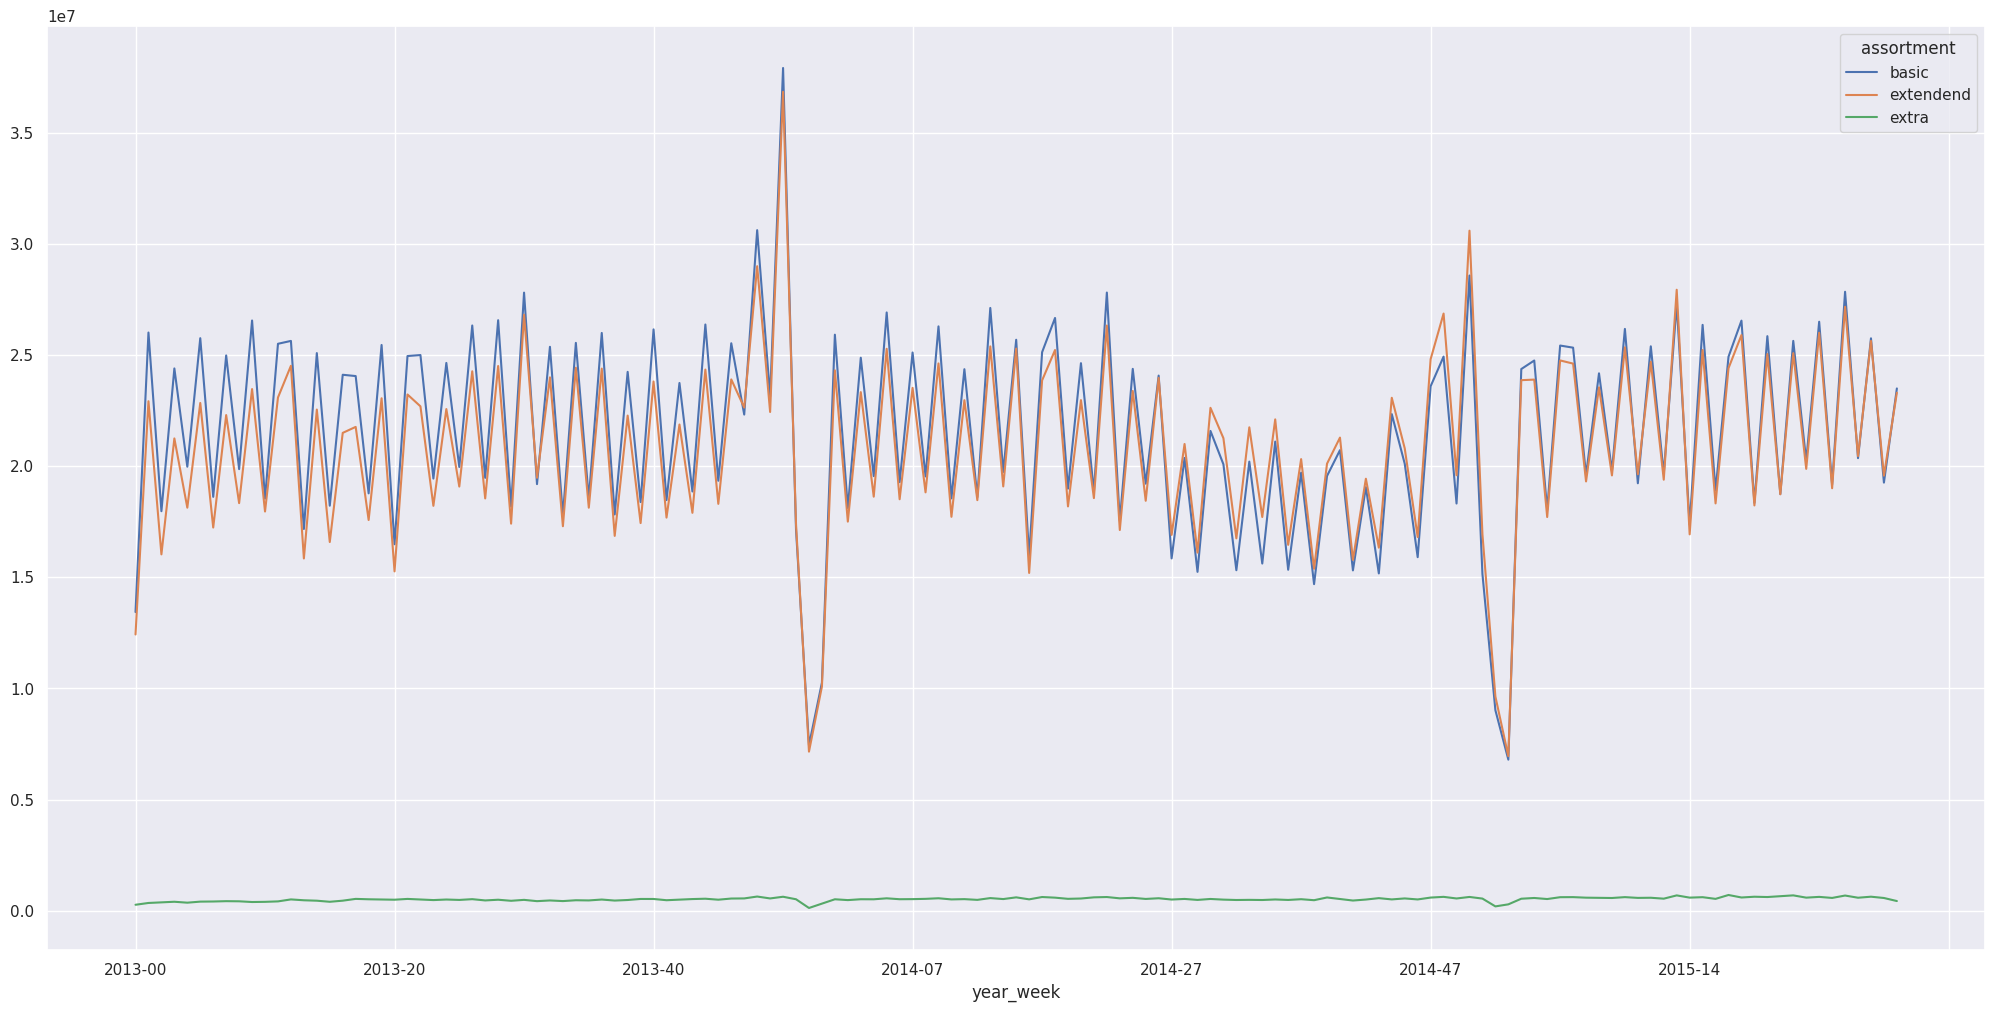

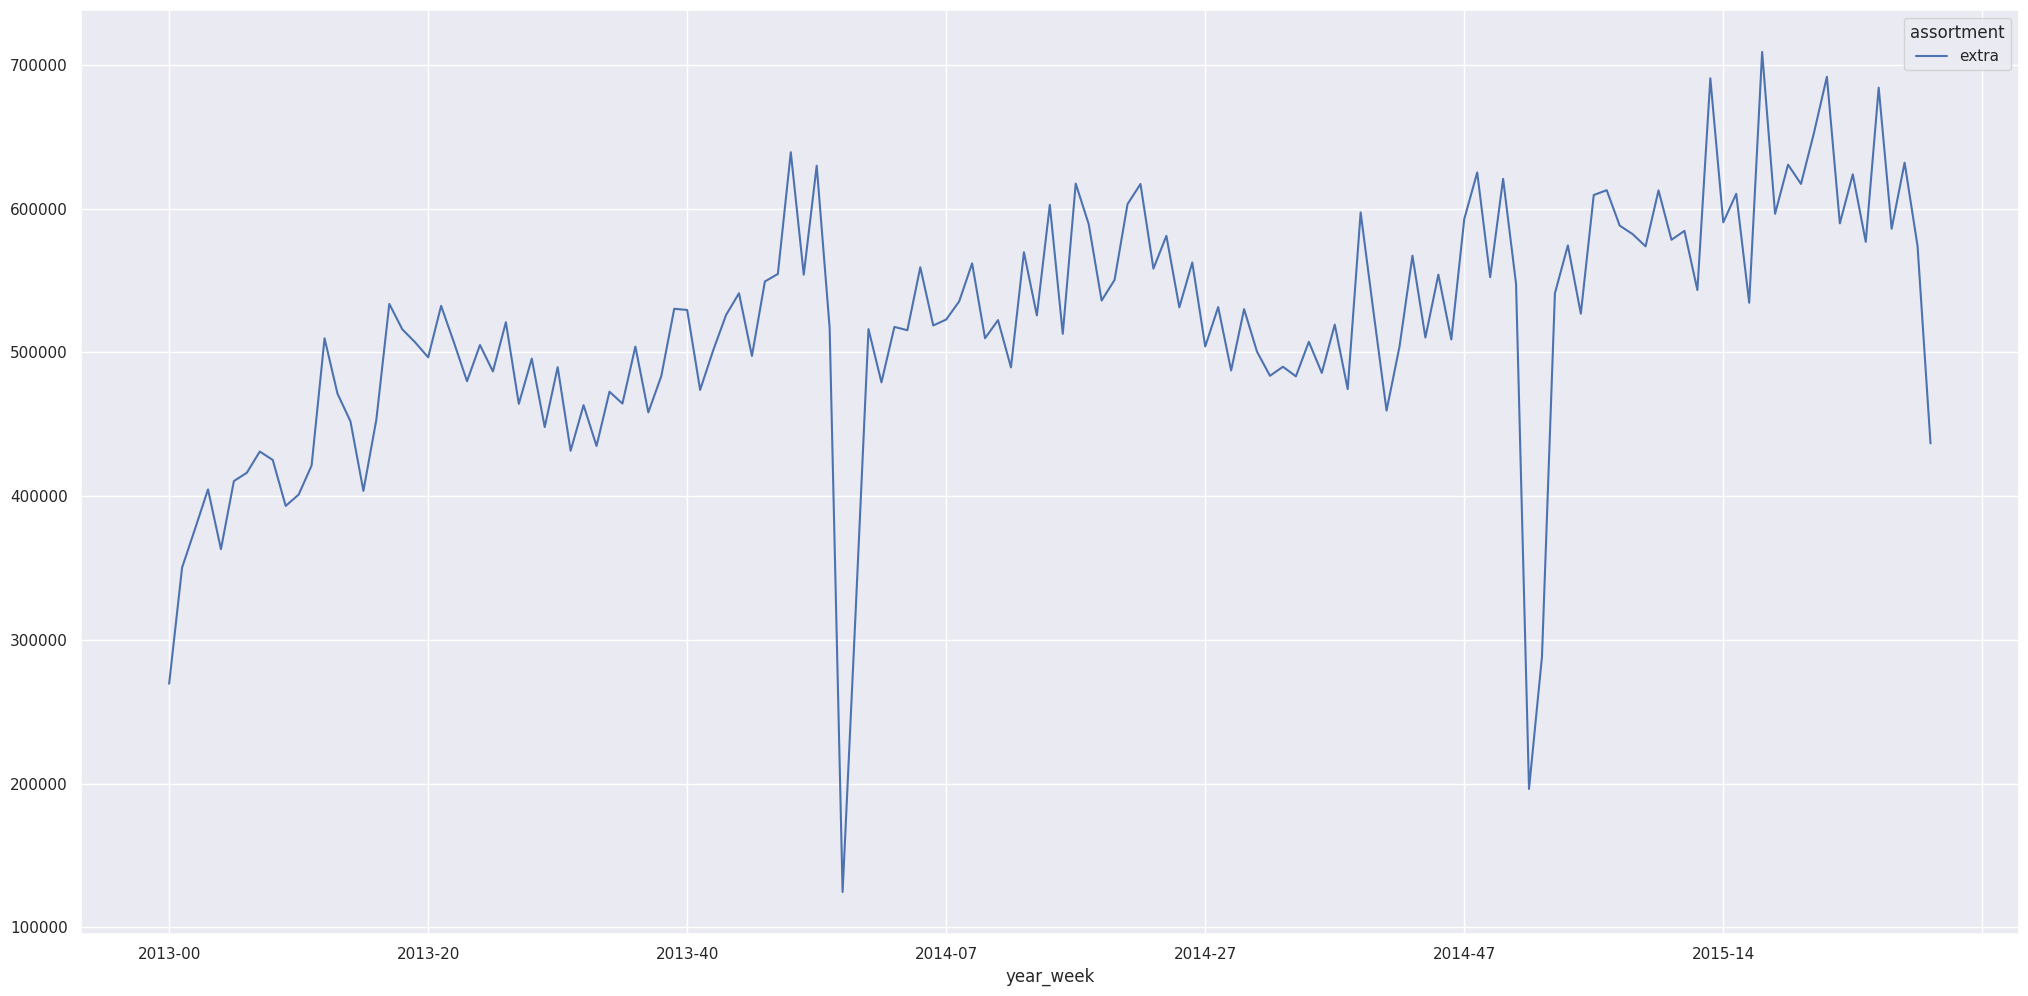

In [33]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();


aux3 = aux2[aux2['assortment'] =='extra' ]
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### **H2.** Lojas com competidores mais próximos devereiam vender menos.
**FALSA** Lojas com competidores mais próximos vendem mais.

/tmp/ipykernel_2904/1703448673.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()


<Axes: >

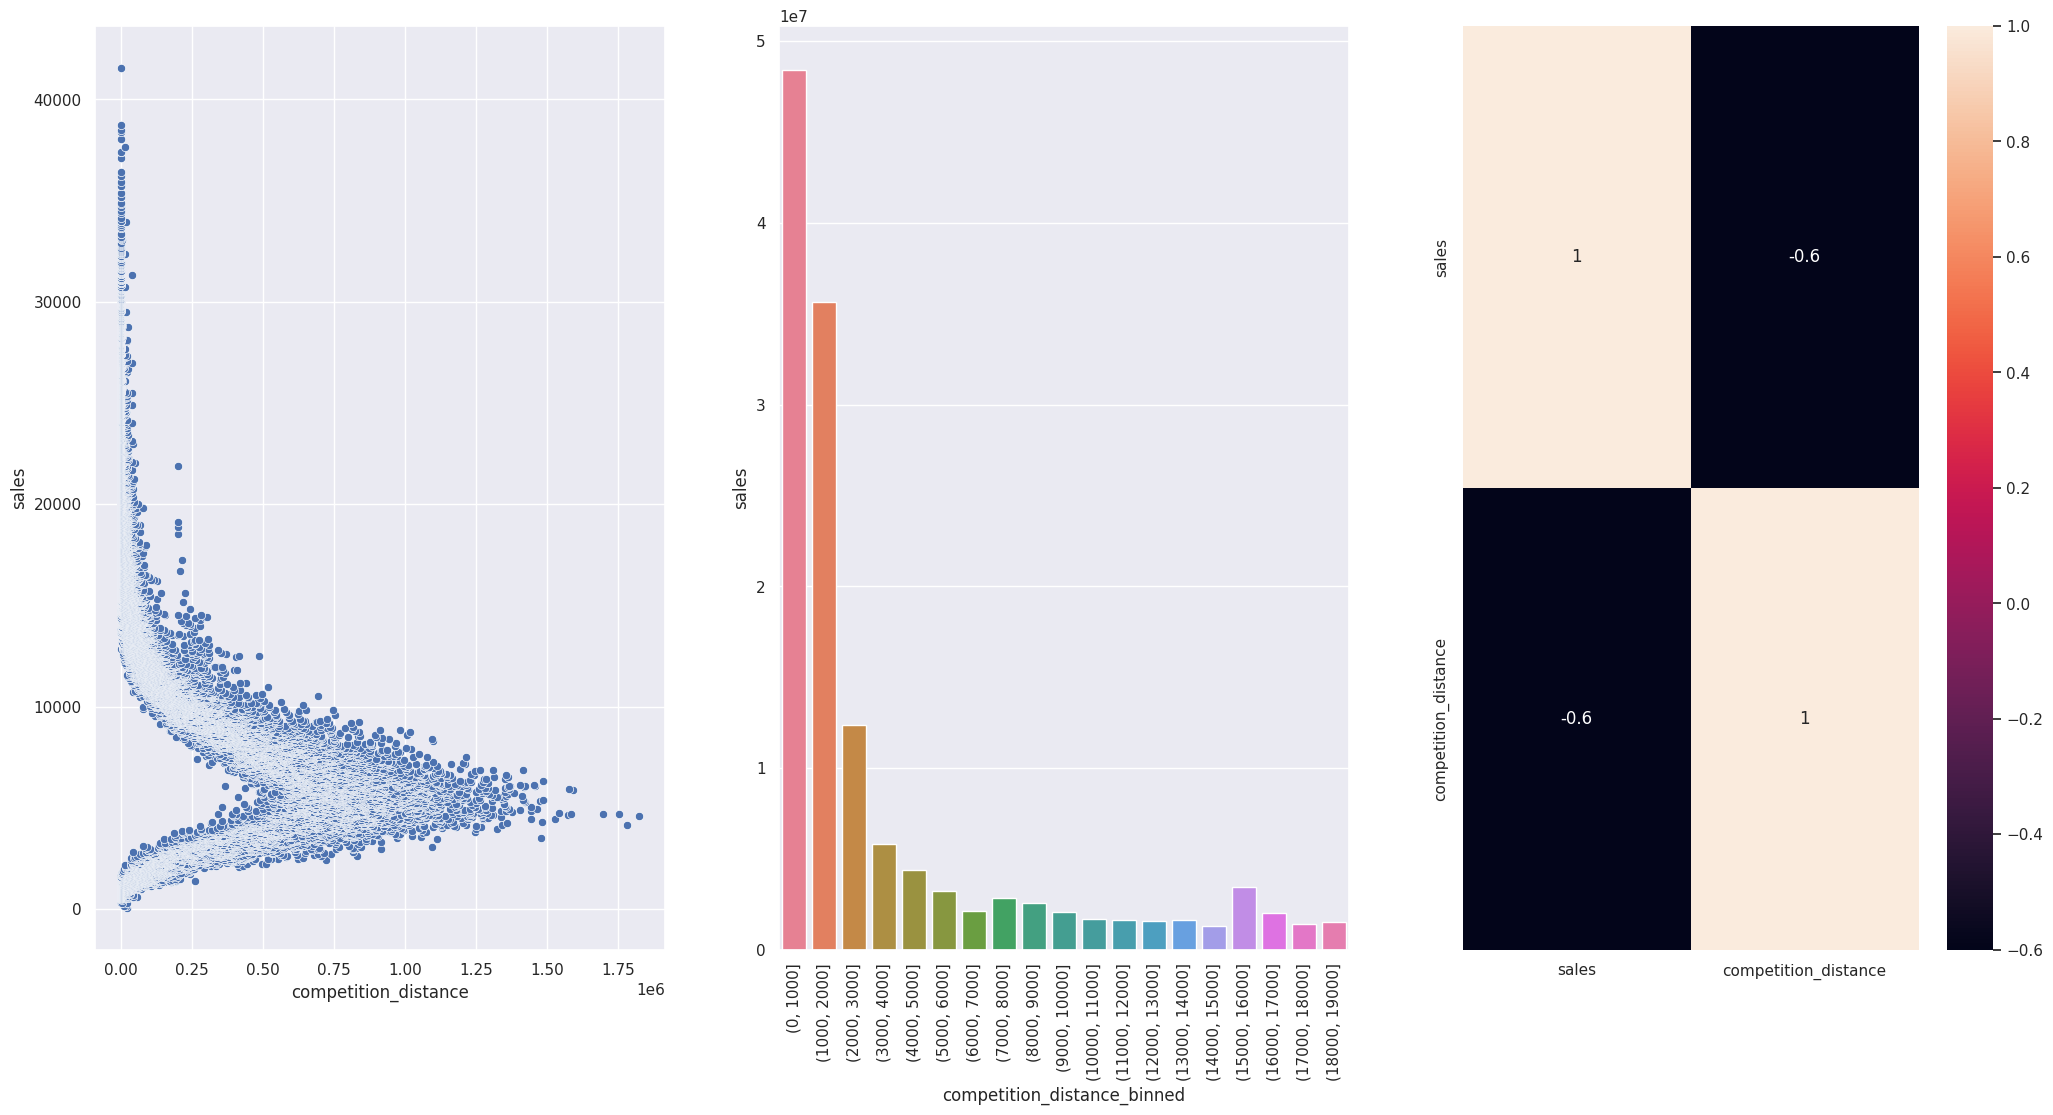

In [34]:
plt.subplot ( 1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index()
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot ( 1, 3, 2)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index()
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( aux2, x='competition_distance_binned', y='sales', hue='competition_distance_binned', legend=False );
plt.xticks(rotation=90);

plt.subplot ( 1, 3, 3)
aux1 = df4[['competition_distance', 'sales']].groupby( 'sales' ).sum().reset_index().astype( int )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H3.** Lojas com competidores a mais tempo devereiam vender mais.
**FALSA** Lojas com COMPETIDORES a MAIS TEMPO VENDEM MENOS

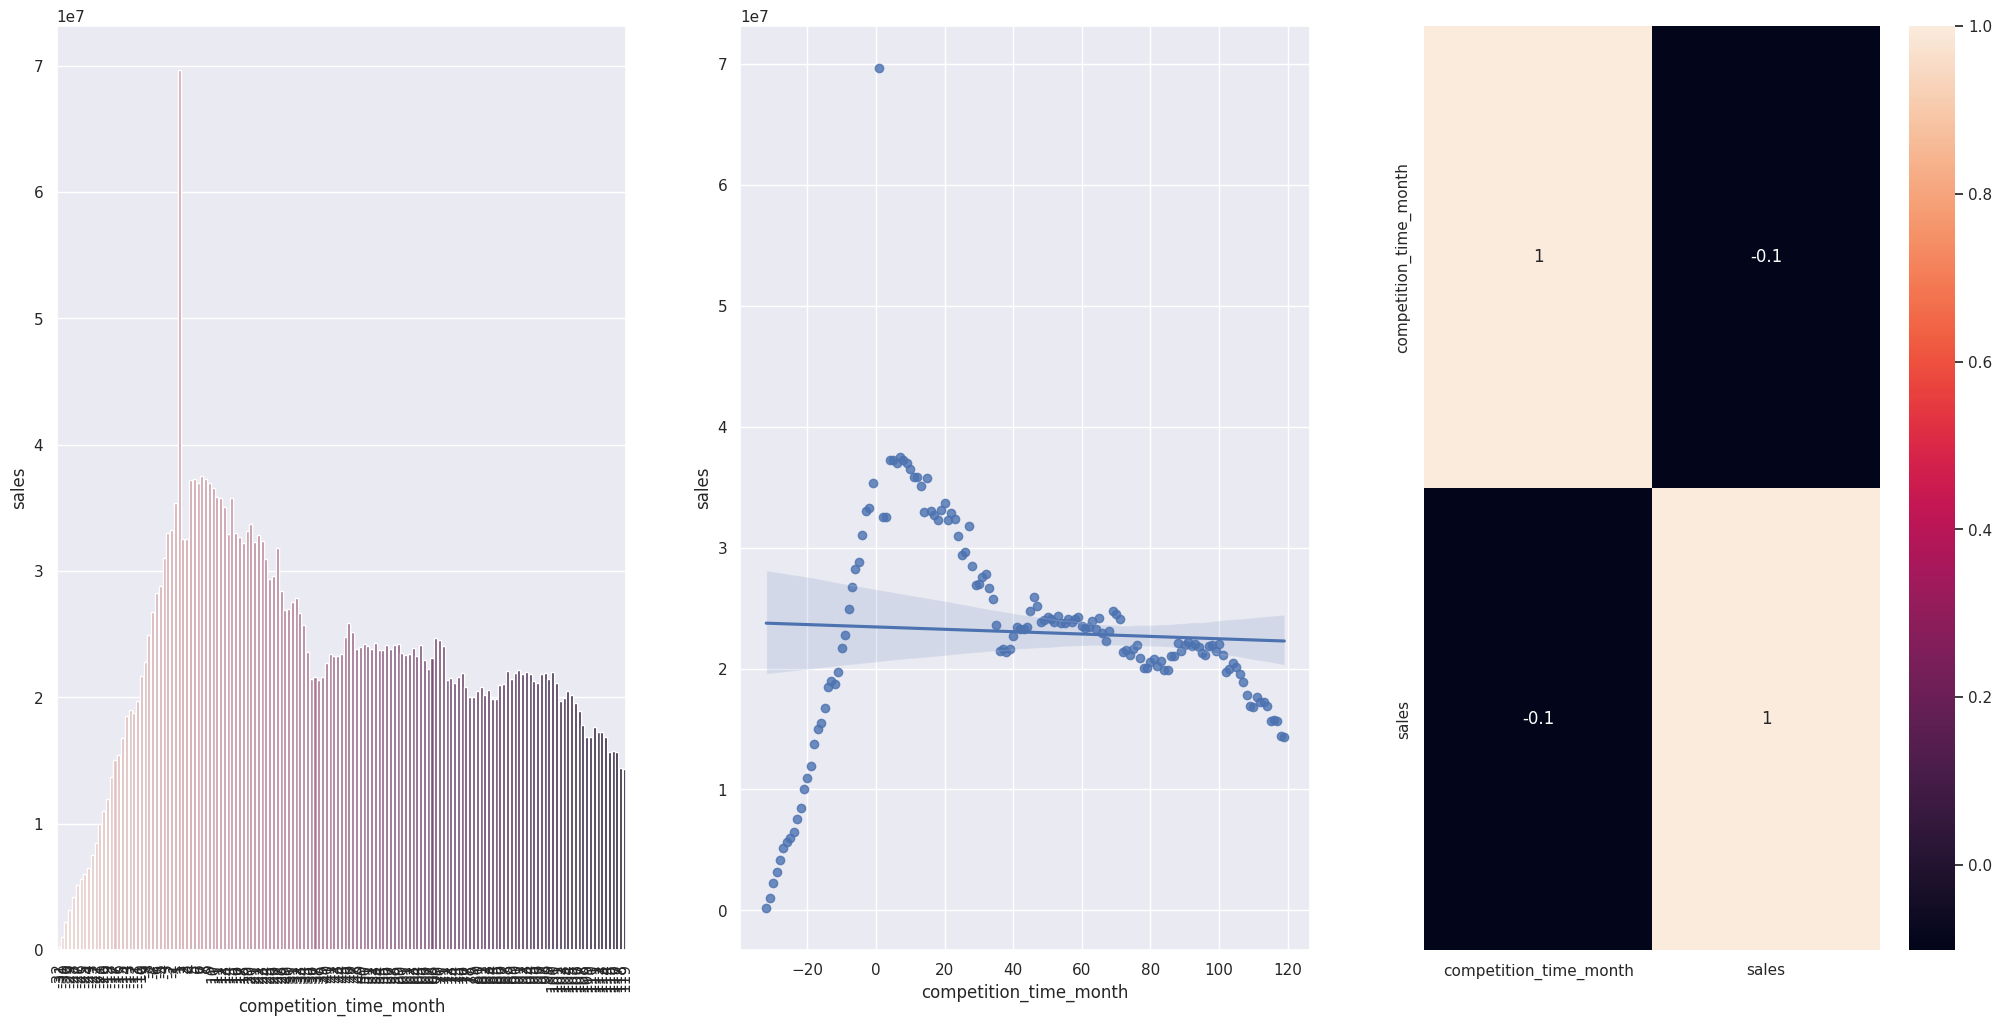

In [40]:
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'competition_time_month', 'sales' ]].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 ) ]
sns.barplot( aux2, x='competition_time_month', y='sales', hue='competition_time_month', legend=False );
plt.xticks(rotation=90);

plt.subplot( 1, 3, 2 )
sns.regplot( aux2, x='competition_time_month', y='sales' );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True);

   ## 4.3 Análise Multivariada